# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
import numpy as np
import os
import datetime
def imread(path):
    from PIL import Image
    return np.array(Image.open(path))

def imresize(img, size):
    from PIL import Image
    return np.array(Image.fromarray((img).astype(np.uint8)).resize(size))
import warnings
warnings.filterwarnings('ignore')

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
train_doc = np.random.permutation(open(r'/content/project_data/train.csv').readlines())
val_doc = np.random.permutation(open(r'/content/project_data/val.csv').readlines())
batch_size = 32

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # It is not possible to work with all the 30 images, as it will take too long processing time.
    # So lets choose randomly 18 images
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29] #create a list of image numbers you want to use for a particular video(incase if u want to try with lesser images)
    x, y, z = len(img_idx), 84, 84
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image[:,20:140,:],(84,84)).astype(np.float32)
                    image = image/255.0
                    batch_data[folder,idx,:,:,0] =(image[:,:,0]) #normalise and feed in the image # divide by 255.0
                    batch_data[folder,idx,:,:,1] =(image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] =(image[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 # OHE
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if(len(t)%batch_size)!=0:
            batch_data = np.zeros((len(t)%batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((len(t)%batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(len(t)%batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image[:,20:140,:],(84,84)).astype(np.float32)
                    image = image/255.0
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])#normalise and feed in the image # divide by 255.0
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1 # OHE
            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = r'/content/project_data/train'
val_path = r'/content/project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
# Model 1

# Batch_size = 32
# image_shape = 84, 84, 3
# epochs = 20
# When given the bacth_size of 64 OOM error is generated by the GPU.

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

model = Sequential()
model.add(Conv3D(16, (3, 3, 3), strides=(1,1,1), padding='same', input_shape=(18,84,84,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2),strides=(2,2,1)))

model.add(Conv3D(32, (2, 2, 2), strides=(1,1,1), padding='same', input_shape=(18,84,84,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(2,2,1)))

model.add(Conv3D(64, (2, 2, 2), strides=(1,1,1), padding='same', input_shape=(18,84,84,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), strides=(1,1,1), padding='same', input_shape=(18,84,84,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [8]:
optimiser = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 18, 84, 84, 16)    1312      
_________________________________________________________________
activation (Activation)      (None, 18, 84, 84, 16)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 18, 84, 84, 16)    64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 9, 42, 83, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 9, 42, 83, 32)     4128      
_________________________________________________________________
activation_1 (Activation)    (None, 9, 42, 83, 32)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 42, 83, 32)     1

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [9]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [10]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
# model_init_1-_25_43/model-epoch:01-loss:0.9876-categorical_accuracy:0.76545......

if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
# ModelCheckpoint - saves weight and model after every epoch
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [11]:
# if #images=55, batch_size=5, then we have 11 batches and 11 epochs
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
# if #images=55, batch_size=5, then we have 11 batches and 3 pending images, therefore 12 epoch will be reqd for last 3 images
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [12]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - 75s 2s/step - loss: 2.1737 - categorical_accuracy: 0.2398 - val_loss: 1.6423 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2021-10-2403_40_28.846484/model-00001-2.17369-0.23982-1.64235-0.16000.h5
Epoch 2/20
21/21 [==============================] - 44s 2s/step - loss: 1.6244 - categorical_accuracy: 0.3967 - val_loss: 1.8501 - val_categorical_accuracy: 0.1700

Epoch 00002: saving model to model_init_2021-10-2403_40_28.846484/model-00002-1.62441-0.39668-1.85014-0.17000.h5
Epoch 3/20
21/21 [==============================] - 44s 2s/step - loss: 1.4131 - categorical_accuracy: 0.4359 - val_loss: 2.3851 - val_categorical_accuracy: 0.1500

Epoch 00003: saving model to model_init_2021-10-2403_40_28.846484/model-00003-1.41311-0.43590-2.38514-0.15000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/20
21/21 [======

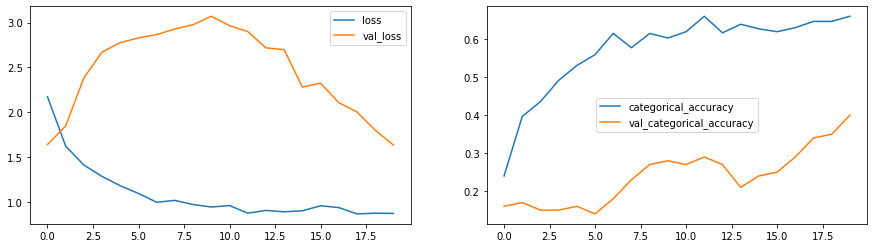

In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].plot(history.history['loss'])   
axes[0].plot(history.history['val_loss'])
axes[0].legend(['loss','val_loss'])

axes[1].plot(history.history['categorical_accuracy'])   
axes[1].plot(history.history['val_categorical_accuracy'])
axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

plt.savefig('model1.png')

## Summary for Model 1:

Even after 20 epochs the model is still overfitting the data. 

In [14]:
#Model 2
train_doc = np.random.permutation(open(r'/content/project_data/train.csv').readlines())
val_doc = np.random.permutation(open(r'/content/project_data/val.csv').readlines())
batch_size = 32

# Image Data Generator
def generator1(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # It is not possible to work with all the 30 images, as it will take too long processing time.
    # So lets choose randomly 18 images
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29] #create a list of image numbers you want to use for a particular video(incase if u want to try with lesser images)
    x, y, z = len(img_idx), 100, 100
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image[:,20:140,:],(100,100)).astype(np.float32)
                    image = image/255.0
                    batch_data[folder,idx,:,:,0] =(image[:,:,0]) #normalise and feed in the image # divide by 255.0
                    batch_data[folder,idx,:,:,1] =(image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] =(image[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 # OHE
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if(len(t)%batch_size)!=0:
            batch_data = np.zeros((len(t)%batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((len(t)%batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(len(t)%batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image[:,20:140,:],(100,100)).astype(np.float32)
                    image = image/255.0
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])#normalise and feed in the image # divide by 255.0
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1 # OHE
            yield batch_data, batch_labels

curr_dt_time = datetime.datetime.now()
train_path = r'/content/project_data/train'
val_path = r'/content/project_data/val'
num_train_sequences = len(train_doc) 
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc) 
print('# validation sequences =', num_val_sequences)
num_epochs = 20 
print ('# epochs =', num_epochs)

# Model 2 after dropping few layers

# Batch_size = 32
# image_shape = 100, 100, 3
# epochs = 20
# When given the bacth_size of 64 OOM error is generated by the GPU.

model1 = Sequential()
model1.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,100,100,3)))
model1.add(BatchNormalization())
model1.add(Activation('elu'))
model1.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model1.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,100,100,3)))
model1.add(BatchNormalization())
model1.add(Activation('elu'))
model1.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model1.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,100,100,3)))
model1.add(BatchNormalization())
model1.add(Activation('elu'))
model1.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model1.add(Flatten())
model1.add(Dropout(0.5))
model1.add(Dense(512, activation='elu'))
model1.add(Dropout(0.5))
model1.add(Dense(5, activation='softmax'))

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [15]:
optimiser1 = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7) #write your optimizer
model1.compile(optimizer=optimiser1, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 18, 100, 100, 64)  5248      
_________________________________________________________________
batch_normalization_6 (Batch (None, 18, 100, 100, 64)  256       
_________________________________________________________________
activation_4 (Activation)    (None, 18, 100, 100, 64)  0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 9, 50, 100, 64)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 9, 50, 100, 128)   221312    
_________________________________________________________________
batch_normalization_7 (Batch (None, 9, 50, 100, 128)   512       
_________________________________________________________________
activation_5 (Activation)    (None, 9, 50, 100, 128)  

In [16]:
train_generator = generator1(train_path, train_doc, batch_size)
val_generator = generator1(val_path, val_doc, batch_size)

In [17]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
# model_init_1-_25_43/model-epoch:01-loss:0.9876-categorical_accuracy:0.76545......

if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
# ModelCheckpoint - saves weight and model after every epoch
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [18]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)

else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [19]:
history1 = model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/project_data/train ; batch size = 32
Epoch 1/20


ResourceExhaustedError: ignored

## Summary for Model 2:
OOM Error because of Large tensor size.

In [20]:
# Model 3
train_doc = np.random.permutation(open(r'/content/project_data/train.csv').readlines())
val_doc = np.random.permutation(open(r'/content/project_data/val.csv').readlines())
batch_size = 10

# Image Data Generator
def generator2(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # It is not possible to work with all the 30 images, as it will take too long processing time.
    # So lets choose randomly 18 images
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29] #create a list of image numbers you want to use for a particular video(incase if u want to try with lesser images)
    x, y, z = len(img_idx), 100, 100
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image[:,20:140,:],(100,100)).astype(np.float32)
                    image = image/255.0
                    batch_data[folder,idx,:,:,0] =(image[:,:,0]) #normalise and feed in the image # divide by 255.0
                    batch_data[folder,idx,:,:,1] =(image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] =(image[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 # OHE
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if(len(t)%batch_size)!=0:
            batch_data = np.zeros((len(t)%batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((len(t)%batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(len(t)%batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image[:,20:140,:],(100,100)).astype(np.float32)
                    image = image/255.0
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])#normalise and feed in the image # divide by 255.0
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1 # OHE
            yield batch_data, batch_labels

curr_dt_time = datetime.datetime.now()
train_path = r'/content/project_data/train'
val_path = r'/content/project_data/val'
num_train_sequences = len(train_doc) 
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc) 
print('# validation sequences =', num_val_sequences)
num_epochs = 20 
print ('# epochs =', num_epochs)

# Model 3 after Resizing the tensor size

# Batch_size = 10
# image_shape = 100, 100, 3
# epochs = 20

model2 = Sequential()
model2.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,100,100,3)))
model2.add(BatchNormalization())
model2.add(Activation('elu'))
model2.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model2.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,100,100,3)))
model2.add(BatchNormalization())
model2.add(Activation('elu'))
model2.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model2.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,100,100,3)))
model2.add(BatchNormalization())
model2.add(Activation('elu'))
model2.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model2.add(Flatten())
model2.add(Dropout(0.5))
model2.add(Dense(512, activation='elu'))
model2.add(Dropout(0.5))
model2.add(Dense(5, activation='softmax'))


# training sequences = 663
# validation sequences = 100
# epochs = 20


In [21]:
optimiser2 = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7) #write your optimizer
model2.compile(optimizer=optimiser2, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 18, 100, 100, 64)  5248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 18, 100, 100, 64)  256       
_________________________________________________________________
activation_7 (Activation)    (None, 18, 100, 100, 64)  0         
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 9, 50, 100, 64)    0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 9, 50, 100, 128)   221312    
_________________________________________________________________
batch_normalization_10 (Batc (None, 9, 50, 100, 128)   512       
_________________________________________________________________
activation_8 (Activation)    (None, 9, 50, 100, 128)  

In [22]:
train_generator2 = generator2(train_path, train_doc, batch_size)
val_generator2 = generator2(val_path, val_doc, batch_size)

In [26]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
# model_init_1-_25_43/model-epoch:01-loss:0.9876-categorical_accuracy:0.76545......

if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
# ModelCheckpoint - saves weight and model after every epoch
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [27]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)

else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [28]:
history2 = model2.fit_generator(train_generator2, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator2, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
67/67 [==============================] - 79s 1s/step - loss: 1.1795 - categorical_accuracy: 0.5837 - val_loss: 3.7607 - val_categorical_accuracy: 0.3000

Epoch 00001: saving model to model_init_2021-10-2404_27_52.977538/model-00001-1.17954-0.58371-3.76069-0.30000.h5
Epoch 2/20
67/67 [==============================] - 79s 1s/step - loss: 0.9539 - categorical_accuracy: 0.6456 - val_loss: 2.1339 - val_categorical_accuracy: 0.4300

Epoch 00002: saving model to model_init_2021-10-2404_27_52.977538/model-00002-0.95393-0.64555-2.13391-0.43000.h5
Epoch 3/20
67/67 [==============================] - 79s 1s/step - loss: 0.9351 - categorical_accuracy: 0.6682 - val_loss: 2.2879 - val_categorical_accuracy: 0.4500

Epoch 00003: saving model to model_init_2021-10-2404_27_52.977538/model-00003-0.93512-0.66817-2.28786-0.45000.h5
Epoch 4/20
67/67 [==============================] - 79s 1s/step - loss: 0.9533 - categorical_accuracy: 0.6531 - val_loss: 1.5766 - val_categorical_accuracy: 0.5700

E

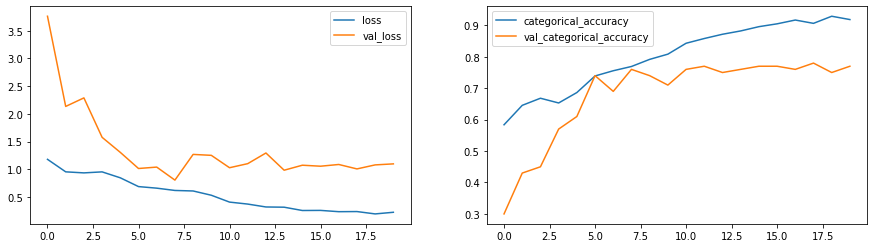

In [29]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].plot(history2.history['loss'])   
axes[0].plot(history2.history['val_loss'])
axes[0].legend(['loss','val_loss'])

axes[1].plot(history2.history['categorical_accuracy'])   
axes[1].plot(history2.history['val_categorical_accuracy'])
axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

plt.savefig('Model3.png')

## Summary for model 3:

After removing few layers model is generalising data so changing tensor shape.

best model: 'model-00012-0.37239-0.85822-1.10159-0.77000.h5'

accuracy : train - 87% val - 75%

In [30]:
train_doc = np.random.permutation(open(r'/content/project_data/train.csv').readlines())
val_doc = np.random.permutation(open(r'/content/project_data/val.csv').readlines())
batch_size = 10

In [31]:
def generator3(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # It is not possible to work with all the 30 images, as it will take too long processing time.
    # So lets choose randomly 18 images
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29] #create a list of image numbers you want to use for a particular video(incase if u want to try with lesser images)
    x, y, z = len(img_idx), 84, 84
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image[:,20:140,:],(84,84)).astype(np.float32)
                    image = image/255.0
                    batch_data[folder,idx,:,:,0] =(image[:,:,0]) #normalise and feed in the image # divide by 255.0
                    batch_data[folder,idx,:,:,1] =(image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] =(image[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 # OHE
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if(len(t)%batch_size)!=0:
            batch_data = np.zeros((len(t)%batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((len(t)%batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(len(t)%batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image[:,20:140,:],(84,84)).astype(np.float32)
                    image = image/255.0
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])#normalise and feed in the image # divide by 255.0
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1 # OHE
            yield batch_data, batch_labels


In [32]:
curr_dt_time = datetime.datetime.now()
train_path = r'/content/project_data/train'
val_path = r'/content/project_data/val'
num_train_sequences = len(train_doc) 
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc) 
print('# validation sequences =', num_val_sequences)
num_epochs = 20 
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [33]:
#Model 4

#Final Model

# Batch_size = 10
# image_shape = 84, 84, 3
# epochs = 20

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
model3 = Sequential()
model3.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,84,84,3)))
model3.add(BatchNormalization())
model3.add(Activation('elu'))
model3.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model3.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,84,84,3)))
model3.add(BatchNormalization())
model3.add(Activation('elu'))
model3.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model3.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same', input_shape=(18,84,84,3)))
model3.add(BatchNormalization())
model3.add(Activation('elu'))
model3.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model3.add(Flatten())
model3.add(Dropout(0.5))
model3.add(Dense(512, activation='elu'))
model3.add(Dropout(0.5))
model3.add(Dense(5, activation='softmax'))

In [34]:
optimiser3 = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7) #write your optimizer
model3.compile(optimizer=optimiser3, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_10 (Conv3D)           (None, 18, 84, 84, 64)    5248      
_________________________________________________________________
batch_normalization_12 (Batc (None, 18, 84, 84, 64)    256       
_________________________________________________________________
activation_10 (Activation)   (None, 18, 84, 84, 64)    0         
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 9, 42, 84, 64)     0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 9, 42, 84, 128)    221312    
_________________________________________________________________
batch_normalization_13 (Batc (None, 9, 42, 84, 128)    512       
_________________________________________________________________
activation_11 (Activation)   (None, 9, 42, 84, 128)   

In [35]:
train_generator3 = generator3(train_path, train_doc, batch_size)
val_generator3 = generator3(val_path, val_doc, batch_size)

In [36]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
# model_init_1-_25_43/model-epoch:01-loss:0.9876-categorical_accuracy:0.76545......

if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
# ModelCheckpoint - saves weight and model after every epoch
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [37]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)

else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [38]:
history3 = model3.fit_generator(train_generator3, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator3, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - 65s 923ms/step - loss: 7.4663 - categorical_accuracy: 0.2896 - val_loss: 3.2390 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2021-10-2405_25_20.907875/model-00001-7.46627-0.28959-3.23898-0.16000.h5
Epoch 2/20
67/67 [==============================] - 60s 901ms/step - loss: 1.9078 - categorical_accuracy: 0.3725 - val_loss: 3.7121 - val_categorical_accuracy: 0.1700

Epoch 00002: saving model to model_init_2021-10-2405_25_20.907875/model-00002-1.90776-0.37255-3.71212-0.17000.h5
Epoch 3/20
67/67 [==============================] - 60s 899ms/step - loss: 1.7373 - categorical_accuracy: 0.4178 - val_loss: 5.6999 - val_categorical_accuracy: 0.2300

Epoch 00003: saving model to model_init_2021-10-2405_25_20.907875/model-00003-1.73728-0.41780-5.69991-0.23000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/20
67/6

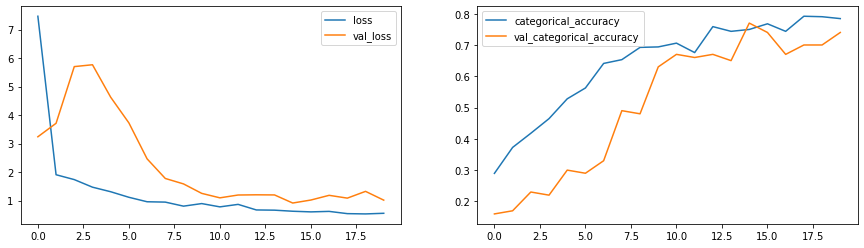

In [39]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].plot(history3.history['loss'])   
axes[0].plot(history3.history['val_loss'])
axes[0].legend(['loss','val_loss'])

axes[1].plot(history3.history['categorical_accuracy'])   
axes[1].plot(history3.history['val_categorical_accuracy'])
axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

plt.savefig('Model3.png')

## Summary for model 4:

After changing tensor shape acheived good accuracy

best model: 'model-00019-0.53358-0.79035-1.32454-0.70000.h5'

accuracy : train - 79% val - 70%

# Using CNN + RNN

CNN - to extract features 
RNN - use features extracted from the CNN model and to train the model

# CNN + LSTM

In [40]:
train_doc = np.random.permutation(open(r'/content/project_data/train.csv').readlines())
val_doc = np.random.permutation(open(r'/content/project_data/val.csv').readlines())
batch_size = 10

In [41]:
def generator4(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # It is not possible to work with all the 30 images, as it will take too long processing time.
    # So lets choose randomly 18 images
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29] #create a list of image numbers you want to use for a particular video(incase if u want to try with lesser images)
    x, y, z = len(img_idx), 120, 120
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image[:,20:140,:],(120,120)).astype(np.float32)
                    image = image/255.0
                    batch_data[folder,idx,:,:,0] =(image[:,:,0]) #normalise and feed in the image # divide by 255.0
                    batch_data[folder,idx,:,:,1] =(image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] =(image[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 # OHE
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if(len(t)%batch_size)!=0:
            batch_data = np.zeros((len(t)%batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((len(t)%batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(len(t)%batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image[:,20:140,:],(120,120)).astype(np.float32)
                    image = image/255.0
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])#normalise and feed in the image # divide by 255.0
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1 # OHE
            yield batch_data, batch_labels


In [42]:
curr_dt_time = datetime.datetime.now()
train_path = r'/content/project_data/train'
val_path = r'/content/project_data/val'
num_train_sequences = len(train_doc) 
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc) 
print('# validation sequences =', num_val_sequences)
num_epochs = 20 
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [43]:
# CNN-RNN model 

# Model 1


# Batch_size = 10
# image_shape = 120, 120, 3
# epochs = 20

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

model_rnn = Sequential()
model_rnn.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(18,120,120,3)))
model_rnn.add(TimeDistributed(BatchNormalization()))
model_rnn.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_rnn.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_rnn.add(TimeDistributed(BatchNormalization()))
model_rnn.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_rnn.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_rnn.add(TimeDistributed(BatchNormalization()))
model_rnn.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_rnn.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_rnn.add(TimeDistributed(BatchNormalization()))
model_rnn.add(TimeDistributed(MaxPooling2D((2, 2))))

model_rnn.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_rnn.add(TimeDistributed(BatchNormalization()))
model_rnn.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_rnn.add(TimeDistributed(Flatten()))


model_rnn.add(LSTM(128))
model_rnn.add(Dropout(0.25))
        
model_rnn.add(Dense(128,activation='relu'))
model_rnn.add(Dropout(0.25))
        
model_rnn.add(Dense(5, activation='softmax'))

In [44]:
model_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [45]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
# model_init_1-_25_43/model-epoch:01-loss:0.9876-categorical_accuracy:0.76545......

if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
# ModelCheckpoint - saves weight and model after every epoch
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [46]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)

else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [48]:
train_generator_rnn = generator4(train_path, train_doc, batch_size)
val_generator_rnn = generator4(val_path, val_doc, batch_size)

In [49]:
history_rnn = model.fit_generator(train_generator_rnn, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator_rnn, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/project_data/train ; batch size = 10
Epoch 1/20


InvalidArgumentError: ignored

## Summary for Model 1:

Because of the input image size we are getting OOM error.

# CNN + LSTM

In [50]:
train_doc = np.random.permutation(open(r'/content/project_data/train.csv').readlines())
val_doc = np.random.permutation(open(r'/content/project_data/val.csv').readlines())
batch_size = 10

In [51]:
def generator5(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # It is not possible to work with all the 30 images, as it will take too long processing time.
    # So lets choose randomly 18 images
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29] #create a list of image numbers you want to use for a particular video(incase if u want to try with lesser images)
    x, y, z = len(img_idx), 100, 100
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image[:,20:140,:],(100,100)).astype(np.float32)
                    image = image/255.0
                    batch_data[folder,idx,:,:,0] =(image[:,:,0]) #normalise and feed in the image # divide by 255.0
                    batch_data[folder,idx,:,:,1] =(image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] =(image[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 # OHE
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if(len(t)%batch_size)!=0:
            batch_data = np.zeros((len(t)%batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((len(t)%batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(len(t)%batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image[:,20:140,:],(100,100)).astype(np.float32)
                    image = image/255.0
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])#normalise and feed in the image # divide by 255.0
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1 # OHE
            yield batch_data, batch_labels


In [52]:
curr_dt_time = datetime.datetime.now()
train_path = r'/content/project_data/train'
val_path = r'/content/project_data/val'
num_train_sequences = len(train_doc) 
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc) 
print('# validation sequences =', num_val_sequences)
num_epochs = 20 
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [53]:
train_generator_rnn1 = generator5(train_path, train_doc, batch_size)
val_generator_rnn1 = generator5(val_path, val_doc, batch_size)

In [54]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

# Model 2

# Batch_size = 10
# image_shape = 100, 100, 3
# epochs = 20

model_rnn1 = Sequential()
model_rnn1.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(18,100,100,3)))
model_rnn1.add(TimeDistributed(BatchNormalization()))
model_rnn1.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_rnn1.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_rnn1.add(TimeDistributed(BatchNormalization()))
model_rnn1.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_rnn1.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_rnn1.add(TimeDistributed(BatchNormalization()))
model_rnn1.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_rnn1.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_rnn1.add(TimeDistributed(BatchNormalization()))
model_rnn1.add(TimeDistributed(MaxPooling2D((2, 2))))

model_rnn1.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_rnn1.add(TimeDistributed(BatchNormalization()))
model_rnn1.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_rnn1.add(TimeDistributed(Flatten()))

model_rnn1.add(LSTM(128))
model_rnn1.add(Dropout(0.25))
        
model_rnn1.add(Dense(128,activation='relu'))
model_rnn1.add(Dropout(0.25))
        
model_rnn1.add(Dense(5, activation='softmax'))

In [55]:
model_rnn1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [56]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
# model_init_1-_25_43/model-epoch:01-loss:0.9876-categorical_accuracy:0.76545......

if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
# ModelCheckpoint - saves weight and model after every epoch
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [57]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)

else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [58]:
history_rnn1 = model_rnn1.fit_generator(train_generator_rnn1, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator_rnn1, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - 99s 786ms/step - loss: 1.5540 - categorical_accuracy: 0.3228 - val_loss: 1.6858 - val_categorical_accuracy: 0.1800

Epoch 00001: saving model to model_init_2021-10-2406_04_36.653329/model-00001-1.55402-0.32278-1.68580-0.18000.h5
Epoch 2/20
67/67 [==============================] - 52s 787ms/step - loss: 1.3786 - categorical_accuracy: 0.3937 - val_loss: 1.8005 - val_categorical_accuracy: 0.2400

Epoch 00002: saving model to model_init_2021-10-2406_04_36.653329/model-00002-1.37861-0.39367-1.80048-0.24000.h5
Epoch 3/20
67/67 [==============================] - 52s 782ms/step - loss: 1.4164 - categorical_accuracy: 0.4027 - val_loss: 2.2000 - val_categorical_accuracy: 0.2100

Epoch 00003: saving model to model_init_2021-10-2406_04_36.653329/model-00003-1.41645-0.40271-2.20000-0.21000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/20
67/6

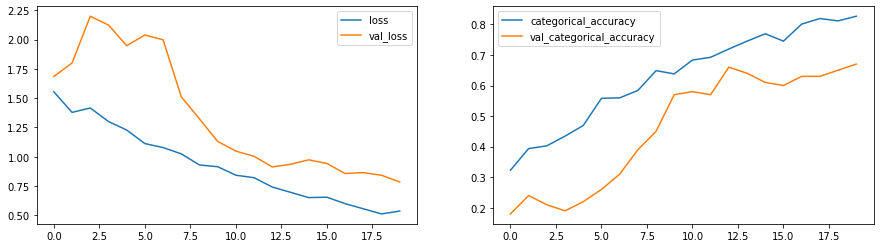

In [76]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].plot(history_rnn1.history['loss'])   
axes[0].plot(history_rnn1.history['val_loss'])
axes[0].legend(['loss','val_loss'])

axes[1].plot(history_rnn1.history['categorical_accuracy'])   
axes[1].plot(history_rnn1.history['val_categorical_accuracy'])
axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

plt.savefig('Model_rnn1.png')

## Summary for Model 2:

After resizing the image size model is working fine.

best model: 'model-00012-0.82044-0.69231-1.00329-0.57000.h5'

accuracy : train - 71% val - 66%

In [59]:
train_doc = np.random.permutation(open(r'/content/project_data/train.csv').readlines())
val_doc = np.random.permutation(open(r'/content/project_data/val.csv').readlines())
batch_size = 10

In [60]:
def generator6(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # It is not possible to work with all the 30 images, as it will take too long processing time.
    # So lets choose randomly 18 images
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29] #create a list of image numbers you want to use for a particular video(incase if u want to try with lesser images)
    x, y, z = len(img_idx), 84, 84
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image[:,20:140,:],(84,84)).astype(np.float32)
                    image = image/255.0
                    batch_data[folder,idx,:,:,0] =(image[:,:,0]) #normalise and feed in the image # divide by 255.0
                    batch_data[folder,idx,:,:,1] =(image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] =(image[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 # OHE
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if(len(t)%batch_size)!=0:
            batch_data = np.zeros((len(t)%batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((len(t)%batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(len(t)%batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image[:,20:140,:],(84,  84)).astype(np.float32)
                    image = image/255.0
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])#normalise and feed in the image # divide by 255.0
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1 # OHE
            yield batch_data, batch_labels


In [61]:
curr_dt_time = datetime.datetime.now()
train_path = r'/content/project_data/train'
val_path = r'/content/project_data/val'
num_train_sequences = len(train_doc) 
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc) 
print('# validation sequences =', num_val_sequences)
num_epochs = 20 
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [62]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

# Batch_size = 10
# image_shape = 84, 84, 3
# epochs = 20

model_rnn2 = Sequential()
model_rnn2.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(18,84,84,3)))
model_rnn2.add(TimeDistributed(BatchNormalization()))
model_rnn2.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_rnn2.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_rnn2.add(TimeDistributed(BatchNormalization()))
model_rnn2.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_rnn2.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_rnn2.add(TimeDistributed(BatchNormalization()))
model_rnn2.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_rnn2.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_rnn2.add(TimeDistributed(BatchNormalization()))
model_rnn2.add(TimeDistributed(MaxPooling2D((2, 2))))

model_rnn2.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_rnn2.add(TimeDistributed(BatchNormalization()))
model_rnn2.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_rnn2.add(TimeDistributed(Flatten()))

model_rnn2.add(LSTM(128))
model_rnn2.add(Dropout(0.25))
        
model_rnn2.add(Dense(128,activation='relu'))
model_rnn2.add(Dropout(0.25))
        
model_rnn2.add(Dense(5, activation='softmax'))

In [63]:
model_rnn2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_32 (TimeDis (None, 18, 84, 84, 16)    448       
_________________________________________________________________
time_distributed_33 (TimeDis (None, 18, 84, 84, 16)    64        
_________________________________________________________________
time_distributed_34 (TimeDis (None, 18, 42, 42, 16)    0         
_________________________________________________________________
time_distributed_35 (TimeDis (None, 18, 42, 42, 32)    4640      
_________________________________________________________________
time_distributed_36 (TimeDis (None, 18, 42, 42, 32)    128       
_________________________________________________________________
time_distributed_37 (TimeDis (None, 18, 21, 21, 32)    0         
_________________________________________________________________
time_distributed_38 (TimeDis (None, 18, 21, 21, 64)   

In [67]:
model_rnn2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [68]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
# model_init_1-_25_43/model-epoch:01-loss:0.9876-categorical_accuracy:0.76545......

if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
# ModelCheckpoint - saves weight and model after every epoch
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [69]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)

else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [70]:
train_generator_rnn2 = generator6(train_path, train_doc, batch_size)
val_generator_rnn2 = generator6(val_path, val_doc, batch_size)

In [71]:
history_rnn2 = model_rnn2.fit_generator(train_generator_rnn2, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator_rnn2, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/project_data/train ; batch size = 10
Epoch 1/20
67/67 [==============================] - 55s 766ms/step - loss: 1.5289 - categorical_accuracy: 0.3198 - val_loss: 1.9690 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2021-10-2406_30_27.142575/model-00001-1.52894-0.31976-1.96898-0.21000.h5
Epoch 2/20
67/67 [==============================] - 51s 763ms/step - loss: 1.3499 - categorical_accuracy: 0.3952 - val_loss: 1.8859 - val_categorical_accuracy: 0.2200

Epoch 00002: saving model to model_init_2021-10-2406_30_27.142575/model-00002-1.34991-0.39517-1.88591-0.22000.h5
Epoch 3/20
67/67 [==============================] - 50s 754ms/step - loss: 1.2941 - categorical_accuracy: 0.4465 - val_loss: 2.3408 - val_categorical_accuracy: 0.2000

Epoch 00003: saving model to model_init_2021-10-2406_30_27.142575/model-00003-1.29405-0.44646-2.34083-0.20000.h5
Epoch 4/20
67/67 [==============================] - 51s 761ms/step - loss: 1.2590 - categorical_

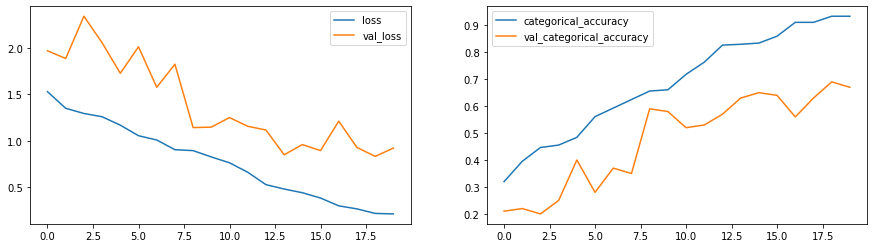

In [72]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].plot(history_rnn2.history['loss'])   
axes[0].plot(history_rnn2.history['val_loss'])
axes[0].legend(['loss','val_loss'])

axes[1].plot(history_rnn2.history['categorical_accuracy'])   
axes[1].plot(history_rnn2.history['val_categorical_accuracy'])
axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

plt.savefig('Model_rnn2.png')

## Summary for Model 3:

After resizing the image size model is working fine.

best model: 'model-00010-0.82597-0.66063-1.14727-0.58000.h5'

accuracy : train - 66% val - 58%

# CNN + RNN

# CNN + GRU

In [73]:
def generator7(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # It is not possible to work with all the 30 images, as it will take too long processing time.
    # So lets choose randomly 18 images
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29] #create a list of image numbers you want to use for a particular video(incase if u want to try with lesser images)
    x, y, z = len(img_idx), 84, 84
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image[:,20:140,:],(84,84)).astype(np.float32)
                    image = image/255.0
                    batch_data[folder,idx,:,:,0] =(image[:,:,0]) #normalise and feed in the image # divide by 255.0
                    batch_data[folder,idx,:,:,1] =(image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] =(image[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 # OHE
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if(len(t)%batch_size)!=0:
            batch_data = np.zeros((len(t)%batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((len(t)%batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(len(t)%batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image[:,20:140,:],(84,84)).astype(np.float32)
                    image = image/255.0
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])#normalise and feed in the image # divide by 255.0
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1 # OHE
            yield batch_data, batch_labels


In [74]:
curr_dt_time = datetime.datetime.now()
train_path = r'/content/project_data/train'
val_path = r'/content/project_data/val'
num_train_sequences = len(train_doc) 
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc) 
print('# validation sequences =', num_val_sequences)
num_epochs = 20 
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


In [75]:
train_generator_rnn3 = generator7(train_path, train_doc, batch_size)
val_generator_rnn3 = generator7(val_path, val_doc, batch_size)

In [77]:
#Model 3

# Batch_size = 10
# image_shape = 84, 84, 3
# epochs = 20


model_rnn3 = Sequential()

model_rnn3.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),input_shape=(18, 84, 84, 3)))
model_rnn3.add(TimeDistributed(BatchNormalization()))
model_rnn3.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_rnn3.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_rnn3.add(TimeDistributed(BatchNormalization()))
model_rnn3.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_rnn3.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_rnn3.add(TimeDistributed(BatchNormalization()))
model_rnn3.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_rnn3.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_rnn3.add(TimeDistributed(BatchNormalization()))
model_rnn3.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_rnn3.add(TimeDistributed(Flatten()))

model_rnn3.add(GRU(64))
model_rnn3.add(Dropout(0.25))
        
model_rnn3.add(Dense(64,activation='relu'))
model_rnn3.add(Dropout(0.25))
        
model_rnn3.add(Dense(5, activation='softmax'))


In [78]:
model_rnn3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])


In [79]:
model_rnn3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_48 (TimeDis (None, 18, 84, 84, 16)    448       
_________________________________________________________________
time_distributed_49 (TimeDis (None, 18, 84, 84, 16)    64        
_________________________________________________________________
time_distributed_50 (TimeDis (None, 18, 42, 42, 16)    0         
_________________________________________________________________
time_distributed_51 (TimeDis (None, 18, 42, 42, 32)    4640      
_________________________________________________________________
time_distributed_52 (TimeDis (None, 18, 42, 42, 32)    128       
_________________________________________________________________
time_distributed_53 (TimeDis (None, 18, 21, 21, 32)    0         
_________________________________________________________________
time_distributed_54 (TimeDis (None, 18, 21, 21, 64)   

In [80]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
# model_init_1-_25_43/model-epoch:01-loss:0.9876-categorical_accuracy:0.76545......

if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
# ModelCheckpoint - saves weight and model after every epoch
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', epsilon=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [81]:
# if #images=55, batch_size=5, then we have 11 batches and 11 epochs
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
# if #images=55, batch_size=5, then we have 11 batches and 3 pending images, therefore 12 epoch will be reqd for last 3 images
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [83]:
history_rnn3 = model_rnn3.fit_generator(train_generator_rnn3, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator_rnn3, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
67/67 [==============================] - 47s 666ms/step - loss: 1.6528 - categorical_accuracy: 0.2715 - val_loss: 2.0623 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2021-10-2406_58_51.027434/model-00001-1.65280-0.27149-2.06228-0.23000.h5
Epoch 2/20
67/67 [==============================] - 44s 668ms/step - loss: 1.4292 - categorical_accuracy: 0.3967 - val_loss: 2.0646 - val_categorical_accuracy: 0.1300

Epoch 00002: saving model to model_init_2021-10-2406_58_51.027434/model-00002-1.42924-0.39668-2.06463-0.13000.h5
Epoch 3/20
67/67 [==============================] - 44s 659ms/step - loss: 1.2788 - categorical_accuracy: 0.4630 - val_loss: 1.8165 - val_categorical_accuracy: 0.2600

Epoch 00003: saving model to model_init_2021-10-2406_58_51.027434/model-00003-1.27878-0.46305-1.81649-0.26000.h5
Epoch 4/20
67/67 [==============================] - 44s 669ms/step - loss: 1.2380 - categorical_accuracy: 0.4902 - val_loss: 1.7600 - val_categorical_accurac

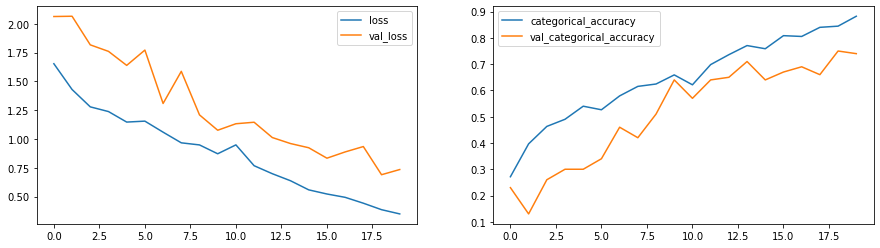

In [85]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].plot(history_rnn3.history['loss'])   
axes[0].plot(history_rnn3.history['val_loss'])
axes[0].legend(['loss','val_loss'])

axes[1].plot(history_rnn3.history['categorical_accuracy'])   
axes[1].plot(history_rnn3.history['val_categorical_accuracy'])
axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

plt.savefig('Model_rnn3.png')

## Summary for Model 3:

After resizing the image size model is working fine.

best model: 'model-00014-0.63799-0.77074-0.96058-0.71000.h5'

accuracy : train - 77% val - 71%

# Experimet Results

# Conv3D Results :

| Experiment | Model | Result | Decision + Accuracy |
| --- | --- | --- | --- |
| 1 | Conv3D | OOM Error | Because of the large batch size(ie., 64) OOM error generated |
| 2 | Conv3D | Model is overfitting | As the Model is overfitting droping few layers |
| 3 | Conv3D | OOM Error | Batchsize is reduced from 32 to 10 |
| 4 | Conv3D | Model is generalising the data | Changing the tensor shape from 100 to 84  train_acc = 87% , val_acc = 75% |
| 5 | Conv3D | Model acheived good accuracy | train_acc = 79% , val_acc = 70% |


# CNN + RNN Results:

| Experiment | Model | Result | Decision + Accuracy |
| --- | --- | --- | --- |
| 1 | CNN + LSTM | OOM Error | Image size is large so changing image size |
| 2 | CNN + LSTM | Model acheived good accuracy | After decreasing image size acheived good accuracy train_acc = 71%, val_acc = 66% |
| 3 | CNN+LSTM | Model Accuracy dropped after image is resized | train_acc = 66%, val_acc = 58% |
| 4 | CNN + GRU | OOM Error | Due to large tensor size OOM error occured changing batch size to 10 again |
| 5 | CNN + GRU | Model acheived good accuracy | train_acc = 77%, val_acc = 71% |


# Summary :

because of the memory constraints only ran for 20 epochs. if increased epoch rate to 30 or 50 can get better model.

Conv3D model gives better accuracy compared to CNN+RNN model

In CNN+RNN model, CNN+GRU model gives CNN+LSTM

